In [16]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import pytv
from scipy.io import loadmat, savemat
from scipy.sparse import coo_matrix
from Image import Image
import os
import torch

In [50]:
im = Image('heart', noise_std=0.1)
y = im.y
y = y.reshape(1,1,y.shape[0],y.shape[1])

In [61]:
#np.random.seed(0)
noise_level = 100
nb_it = 300
regularization = 0.1
step_size = 5e-3 # If step size is too large, loss function may not decrease at every step
cameraman_truth = pytv.utils.cameraman() # Open the cameraman's grayscale image
cameraman_truth = np.reshape(cameraman_truth, (1,1,)+cameraman_truth.shape)
cameraman_noisy = cameraman_truth + noise_level * np.random.rand(*cameraman_truth.shape) # Add noise
cameraman_estimate = np.copy(cameraman_noisy)

im_est = y

loss_fct_CP = np.zeros([nb_it,])

primal_update = np.zeros_like(y)
dual_update_fidelity = np.zeros_like(y)
dual_update_TV = np.zeros_like(y)

# A simple version of the Chambolle & Pock algorithm for image denoising
# Ref: Chambolle, Antonin, and Thomas Pock. "A first-order primal-dual algorithm for convex problems with applications to imaging." Journal of mathematical imaging and vision 40.1 (2011): 120-145.
sigma_D = 0.5
sigma_A = 1.0
tau = 1 / (8 + 1)

for it in range(nb_it):

    # Dual update
    dual_update_fidelity = (dual_update_fidelity + sigma_A * (im_est - y))/(1.0+sigma_A)
    D_x = pytv.tv_operators_CPU.D_hybrid(im_est)
    prox_argument = dual_update_TV + sigma_D * D_x
    dual_update_TV = prox_argument / np.maximum(1.0, np.sqrt(np.sum(prox_argument**2, axis = 1)) / regularization)

    # Primal update
    im_est = im_est- tau * dual_update_fidelity - tau * pytv.tv_operators_CPU.D_T_hybrid(dual_update_TV)

    # Loss function update
    loss_fct_CP[it] = 0.5 * np.sum(np.square(im_est - y)) + regularization * pytv.tv_operators_CPU.compute_L21_norm(D_x)

In [65]:
# plt.imshow(y[0,0])
# plt.show()
# plt.imshow(im_est[0,0])
# plt.show()
# plt.imshow(im.image)
# plt.show()
D_x = pytv.tv_operators_CPU.D_hybrid(im_est)
print(D_x.shape)

(1, 4, 1, 256, 256)


In [157]:
from scipy.sparse import diags, eye, kron

def grad_forward(u):
    # Forward difference
    M,N = u.shape

    one = np.ones([M])
    one[-1] = 0         # Boundary conditions
    D1 = diags([-one, one], [0, 1], shape = [M,M])
    D2 = diags([-one, one], [0, 1], shape = [N,N])

    D1 = kron(eye(N), D1)
    D2 = kron(D2, eye(M))

    return D1, D2

def grad_channel(u, D1, D2, M, N):
    u = u.reshape(-1,1)
    return np.reshape(np.concatenate((D1@u, D2@u),1), [M, N, 2])

def div_channel(v, D1, D2, M, N):
    return np.reshape(D1.T @ np.reshape(v[:,:,0], [M*N, 1]) + D2.T @ np.reshape(v[:,:,1], [M*N, 1]), [M, N])

def KS(v, D1, D2, M, N, l):
    if l > 1:
        return np.concatenate((div_channel(v[:,:,0:2], D1, D2, M, N), div_channel(v[:,:,2:4], D1, D2, M, N), div_channel(v[:,:,4:6], D1, D2, M, N)))

    return div_channel(v[:,:,0:2], D1, D2, M, N)

u = np.array([[1,2],[3,4]])

M,N = u.shape
D1,D2 = grad_forward(u)
grad = grad_channel(u, D1, D2, M, N)
print(KS(grad, D1, D2, M, N, 1))

[[1. 0.]
 [1. 0.]] [[2. 2.]
 [0. 0.]]
[[-3. -1.]
 [ 1.  3.]]


In [151]:
def norms(z, p, dir):
    if p == 1:
        y = np.sum(abs(z),dir)
    elif p == 'inf':
        y = np.max(z.reshape(-1,1))
    else:
        y = np.sum(z**p, dir)**(1/p)

    return y

def proxFS(y, sigma0:float):
    return (y / (1 + sigma0*1)) / np.stack((np.maximum(1, norms(y / (1 + sigma0*1), 2, 2)/1), np.maximum(1, norms(y / (1 + sigma0*1), 2, 2)/1)), 2)

y = np.zeros([3,3,2])
m = np.array([[1,2,3],[4,5,6],[7,8,9]])
y[:,:,0] = m
y[:,:,1] = m
sigma0 = 1

prox = proxFS(y,sigma0)
print(prox[:,:,0])
print(prox[:,:,1])

[[0.5        0.70710678 0.70710678]
 [0.70710678 0.70710678 0.70710678]
 [0.70710678 0.70710678 0.70710678]]
[[0.5        0.70710678 0.70710678]
 [0.70710678 0.70710678 0.70710678]
 [0.70710678 0.70710678 0.70710678]]


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

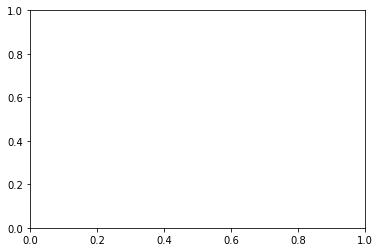

In [75]:
im = Image('heart', build_y = True)
#alphas = np.zeros([256,256])
#alphas[:, 30:] = np.linspace(0, 1, 256-30)
fig, ax = plt.subplots()
color = np.ones([256,256,4])
segmentation = np.zeros([256,256])
segmentation[100:150, 100:150, :] = 1

color[:,:,0] = 0.2
color[:,:,1] = 0.5
color[:,:,2] = 0.7



alphas = np.ones([3,256,256])*0.6
ax.imshow(color)
ax.imshow(color)

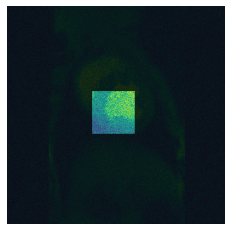

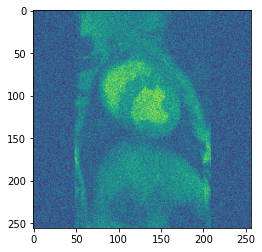

In [90]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

# Load images
color = np.zeros([256,256,4])
color[:,:,0] = 0
color[:,:,1] = 0
color[:,:,2] = 0
image1 = im.image
image2 = color

# Create a mask for the opaque region
mask = np.ones_like(image2[:, :, 3])
mask[100:150, 100:150] = 0
image2[:, :, 3] = mask

# Create figure and subplot
fig, ax = plt.subplots()

# Display the first image
ax.imshow(image1)

# Overlay the modified top image
ax.imshow(image2, alpha = 0.8)

# Adjust plot settings
ax.axis('off')

# Show the stacked images
plt.show()
plt.imshow(im.image)
plt.show()


In [91]:
a = np.array([[1,2],[3,4]])
np.sum(a)

10